In [1]:
# import block
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from tensorflow import keras
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt

In [2]:
# parameter block
image_dimension = (256,256,3)
initial_weights = RandomNormal(stddev=0.02)
file_path_train = 'maps/train/'
file_path_validation = 'maps/val/'
file_path = file_path_train
disc_losses = []
gen_losses = []
epochs = 20
batch_size = 1
learning_rate = 0.0002
beta = 0.5
samples = 3

In [3]:
# load image data
def load_and_normalize():
    inputs = []
    outputs = []
    for image_path in listdir(file_path):
        combined = img_to_array(load_img(file_path + image_path, target_size = (256,512)))
        combined = (combined - 127.5)/127.5
        inputs.append(combined[:,:256])
        outputs.append(combined[:, 256:])
    inputs = asarray(inputs)
    outputs = asarray(outputs)
    return inputs, outputs

In [4]:
# utility function to get real and fake images.
def get_real(batch_size, disc_out_shape):
    source = dataset[0]
    target = dataset[1]
    indices = randint(0, source.shape[0], batch_size)
    sources, targets = source[indices], target[indices]
    y = ones((batch_size, disc_out_shape, disc_out_shape, 1))
    return sources, targets, y

def get_fake(gen, samples, disc_out_shape):
    prediction = gen.predict(samples)
    label = zeros((len(prediction), disc_out_shape, disc_out_shape, 1))
    return prediction, label

In [5]:
# utility function for normed encoder, simple encoder, dropout decoder and simple decoder block 
def normed_encoder(inputs, filters):
    model = keras.Sequential(
    [
        Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
    ])
    return model(inputs)

def encoder(inputs, filters):
    model = keras.Sequential(
    [
        Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        LeakyReLU(alpha=0.2),
    ])
    return model(inputs)

def dropout_decoder(inputs, residual, filters):
    model = keras.Sequential(
    [
        Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
        Dropout(0.5),
    ])
    concat = Concatenate()([model(inputs), residual])
    return Activation('relu')(concat)

def decoder(inputs, residual, filters):
    model = keras.Sequential(
    [
        Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
    ])
    concat = Concatenate()([model(inputs), residual])
    return Activation('relu')(concat)


In [6]:
# discriminator block
def discriminator():    
    source = Input(shape=image_dimension)
    real = Input(shape=image_dimension)
    concat = Concatenate()([source, real])
    disc = keras.Sequential(
    [
        Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        LeakyReLU(alpha=0.2),
        Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(512, (4,4), padding='same', kernel_initializer=initial_weights),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(1, (4,4), padding='same', kernel_initializer=initial_weights),
        Activation('sigmoid'),
    ])
    print(concat.shape)
    output = disc(concat)
    model = Model([source, real], output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate, beta_1=beta), loss_weights=[0.5])
    return model

In [7]:
# generator block
def generator():
    source = Input(shape=image_dimension)
    layer1 = encoder(source, 64)
    layer2 = normed_encoder(layer1, 128)
    layer3 = normed_encoder(layer2, 256)
    layer4 = normed_encoder(layer3, 512)
    layer5 = normed_encoder(layer4, 512)
    layer6 = normed_encoder(layer5, 512)
    layer7 = normed_encoder(layer6, 512)
    encoder_out = Activation('relu')(Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights)(layer7))
    layer8 = dropout_decoder(encoder_out, layer7, 512)
    layer9 = dropout_decoder(layer8, layer6, 512)
    layer10 = dropout_decoder(layer9, layer5, 512)
    layer11 = decoder(layer10, layer4, 512)
    layer12 = decoder(layer11, layer3, 256)
    layer13 = decoder(layer12, layer2, 128)
    layer14 = decoder(layer13, layer1, 64)
    target = Activation('tanh')(Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=initial_weights)(layer14))
    model = Model(source, target)
    return model

In [8]:
# GAN Block
def GAN(gen, disc):
    for layer in disc.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    source = Input(shape=image_dimension)
    gen_output = gen(source)
    disc_output = disc([source, gen_output])
    model = Model(source, [disc_output, gen_output])
    model.compile(loss=['binary_crossentropy', 'mse'], optimizer=Adam(lr=learning_rate, beta_1=beta), loss_weights=[1,100])
    return model

In [9]:
# function to train and check outputs.

def check(iteration, gen, samples=3):
    source, target, y = get_real(samples, 1)
    fake_target, y_fake = get_fake(gen, source, 1)
    source = (source + 1) / 2.0
    target = (target + 1) / 2.0
    fake_target = (fake_target + 1) / 2.0
    for i in range(samples):
        pyplot.subplot(3, samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(source[i])
    for i in range(samples):
        pyplot.subplot(3, samples, 1 + samples + i)
        pyplot.axis('off')
        pyplot.imshow(fake_target[i])
    for i in range(samples):
        pyplot.subplot(3, samples, 1 + samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(target[i])
    image = 'image_%06d.png' % (iteration+1)
    pyplot.savefig(image)
    pyplot.close()
    model_i = 'model_%06d.h5' % (iteration+1)
    gen.save(model_i)
    print('Saved - %s and %s' % (image, model_i))
    
    
def train(epochs, batch_size):
    disc = discriminator()
    gen = generator()
    gan = GAN(gen, disc)
    batches = int(len(dataset[0])/batch_size) 
    iterations = epochs * batches 
    for i in range(iterations):
        source, target, y = get_real(batch_size, disc.output_shape[1])
        fake_target, y_fake = get_fake(gen, source, disc.output_shape[1])
        disc_loss_real = disc.train_on_batch([source, target], y)
        disc_loss_fake = disc.train_on_batch([source, fake_target], y_fake)
        gen_loss = gan.train_on_batch(source, [y, target])[0]
        if i%100 == 0:
            print("Iter " + str(i + 1) + " Discriminator loss = " + str(disc_loss_real + disc_loss_fake) 
                  + " Generator loss = " + str(gen_loss))
        if i%batches == 0:
            disc_losses.append(disc_loss_real + disc_loss_fake)
            gen_losses.append(gen_loss)
        if (i) % (100) == 0:
            check(i, gen, samples)

In [10]:
dataset = load_and_normalize()
image_shape = dataset[0].shape[1:]
train(epochs,batch_size)

2021-12-04 18:02:59.819141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(None, 256, 256, 6)


2021-12-04 18:03:00.663997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Iter 1 Discriminator loss = 1.1863961815834045 Generator loss = 63.0358772277832
Saved - image_000001.png and model_000001.h5
Iter 101 Discriminator loss = 0.008173287380486727 Generator loss = 2.4089691638946533
Saved - image_000101.png and model_000101.h5
Iter 201 Discriminator loss = 0.010468316962942481 Generator loss = 5.493248462677002
Saved - image_000201.png and model_000201.h5
Iter 301 Discriminator loss = 0.11535918340086937 Generator loss = 3.4977192878723145
Saved - image_000301.png and model_000301.h5
Iter 401 Discriminator loss = 0.020567696541547775 Generator loss = 2.0745105743408203
Saved - image_000401.png and model_000401.h5
Iter 501 Discriminator loss = 0.4917239546775818 Generator loss = 3.8835465908050537
Saved - image_000501.png and model_000501.h5
Iter 601 Discriminator loss = 0.03929952159523964 Generator loss = 8.374744415283203
Saved - image_000601.png and model_000601.h5
Iter 701 Discriminator loss = 0.14725811779499054 Generator loss = 1.4357775449752808
Sa

Saved - image_006101.png and model_006101.h5
Iter 6201 Discriminator loss = 7.976895176398102e-05 Generator loss = 0.8889662027359009
Saved - image_006201.png and model_006201.h5
Iter 6301 Discriminator loss = 6.078704245737754e-05 Generator loss = 1.4138438701629639
Saved - image_006301.png and model_006301.h5
Iter 6401 Discriminator loss = 4.3452611862448975e-05 Generator loss = 0.9483022689819336
Saved - image_006401.png and model_006401.h5
Iter 6501 Discriminator loss = 0.0011527558017405681 Generator loss = 1.5500508546829224
Saved - image_006501.png and model_006501.h5
Iter 6601 Discriminator loss = 3.5462031519273296e-05 Generator loss = 3.704967975616455
Saved - image_006601.png and model_006601.h5
Iter 6701 Discriminator loss = 2.404301085334737e-05 Generator loss = 0.7950467467308044
Saved - image_006701.png and model_006701.h5
Iter 6801 Discriminator loss = 4.293996425985824e-05 Generator loss = 1.5088145732879639
Saved - image_006801.png and model_006801.h5
Iter 6901 Discri

Saved - image_012201.png and model_012201.h5
Iter 12301 Discriminator loss = 6.87749729877396e-06 Generator loss = 0.6909559965133667
Saved - image_012301.png and model_012301.h5
Iter 12401 Discriminator loss = 3.3239425647479948e-06 Generator loss = 0.8513907194137573
Saved - image_012401.png and model_012401.h5
Iter 12501 Discriminator loss = 3.97885526126629e-06 Generator loss = 0.17550550401210785
Saved - image_012501.png and model_012501.h5
Iter 12601 Discriminator loss = 0.0001566847859066911 Generator loss = 1.0885165929794312
Saved - image_012601.png and model_012601.h5
Iter 12701 Discriminator loss = 0.0003848902561003342 Generator loss = 2.4888906478881836
Saved - image_012701.png and model_012701.h5
Iter 12801 Discriminator loss = 0.0015121659307624213 Generator loss = 0.8916628360748291
Saved - image_012801.png and model_012801.h5
Iter 12901 Discriminator loss = 6.445635153795592e-05 Generator loss = 1.3127089738845825
Saved - image_012901.png and model_012901.h5
Iter 13001

Saved - image_018301.png and model_018301.h5
Iter 18401 Discriminator loss = 0.0001232354716194095 Generator loss = 0.6203417181968689
Saved - image_018401.png and model_018401.h5
Iter 18501 Discriminator loss = 2.5992566406785045e-05 Generator loss = 0.27114206552505493
Saved - image_018501.png and model_018501.h5
Iter 18601 Discriminator loss = 0.0019487271492835134 Generator loss = 1.0722743272781372
Saved - image_018601.png and model_018601.h5
Iter 18701 Discriminator loss = 0.0003721955872606486 Generator loss = 0.7257238626480103
Saved - image_018701.png and model_018701.h5
Iter 18801 Discriminator loss = 0.0008408506109844893 Generator loss = 0.6408101916313171
Saved - image_018801.png and model_018801.h5
Iter 18901 Discriminator loss = 0.00015502684254897758 Generator loss = 0.5914281606674194
Saved - image_018901.png and model_018901.h5
Iter 19001 Discriminator loss = 6.253911396925105e-05 Generator loss = 0.18243557214736938
Saved - image_019001.png and model_019001.h5
Iter 1

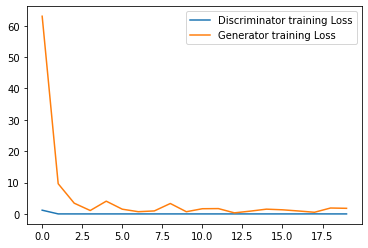

In [12]:
plt.plot(disc_losses, label = "Discriminator training Loss")
plt.plot(gen_losses, label = "Generator training Loss")
plt.legend()

In [13]:
# testing the result of the model
file_path = file_path_validation
dataset = load_and_normalize()
savedModel = 'model_021901.h5'
model = keras.models.load_model(savedModel)

In [14]:
# Getting the RMSE for the model
import numpy as np
import math
mse = 0
for i in range(dataset[0].shape[0]):
    temp = dataset[0][i]
    temp = np.reshape(temp, (1, 256,256,3))
    p = model.predict(temp)
    mse += (np.square(p - dataset[1][i])).mean(axis=None)
rmse = math.sqrt(mse/dataset[0].shape[0])
print(rmse)

0.12832356341601536
